#Загрузка библиотек и данных

In [ ]:
import os
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd

In [ ]:
!mkdir /root/.kaggle
import json
kaggle = {"username":"yanapple","key":"53c4e2d6e293bb5024208c4fdab61b4e"}
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle, f)

!chmod 600 /root/.kaggle/kaggle.json
#Загружаем данные выбранного соревнования
!kaggle datasets download mhantor/russian-voice-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
... resuming from 436207616 bytes (955444219 bytes left) ...
100% 1.29G/1.30G [00:08<00:00, 84.8MB/s]
100% 1.30G/1.30G [00:08<00:00, 109MB/s] 


In [ ]:
! unzip russian-voice-dataset

Archive:  russian-voice-dataset.zip
  inflating: Disorder Voices/Disorder Voices/1.wav  
  inflating: Disorder Voices/Disorder Voices/10.wav  
  inflating: Disorder Voices/Disorder Voices/100.wav  
  inflating: Disorder Voices/Disorder Voices/1000.wav  
  inflating: Disorder Voices/Disorder Voices/1001.wav  
  inflating: Disorder Voices/Disorder Voices/1002.wav  
  inflating: Disorder Voices/Disorder Voices/1003.wav  
  inflating: Disorder Voices/Disorder Voices/1004.wav  
  inflating: Disorder Voices/Disorder Voices/1005.wav  
  inflating: Disorder Voices/Disorder Voices/1006.wav  
  inflating: Disorder Voices/Disorder Voices/1007.wav  
  inflating: Disorder Voices/Disorder Voices/1008.wav  
  inflating: Disorder Voices/Disorder Voices/1009.wav  
  inflating: Disorder Voices/Disorder Voices/101.wav  
  inflating: Disorder Voices/Disorder Voices/1010.wav  
  inflating: Disorder Voices/Disorder Voices/1011.wav  
  inflating: Disorder Voices/Disorder Voices/1012.wav  
  inflating: Disord

#Предобработка данных

##  Функции и анализ очистки от шума

Вариации расчета кратковременной энергии.

Если длина шага равна размеру окна, то накладывания нет, иначе разница между фреймами составит их разность - количество уникальных фреймов между двумя.

In [ ]:
sample_rate=22059

In [ ]:
def short_time_energy_2(signal): #просто иной способ рассчета длины шага и длины фрейма
  frame_length = int(10 * 22050 / 1000)
  frame_step = int(4 * 22050 / 1000)
  # framed_signal = np.array([signal[i:i+frame_length] for i in range(0, len(signal)-frame_length, frame_step)])
  framed_signal = librosa.util.frame(x=signal, frame_length=frame_length, axis=0, hop_length=frame_step )
  energy = np.sum(framed_signal**2,axis=1)
  return framed_signal

In [ ]:
def short_time_energy_1(signal): #без накладывания "окна" (наложение окна позволяет избежать неких "лепестков" на концах графика. Применяется в ненакладываемых фреймах)
  frame_length = 10
  frame_step = 10
  framed_signal = librosa.util.frame(x=signal, frame_length=frame_length, axis=0, hop_length=frame_step )
  energy = np.sum(framed_signal**2,axis=1)
  return energy

In [ ]:

def short_time_energy_0(signal): #так называемое overlapping фреймирование, с наложением след идущих кадров с предыдущими
  frame_length = 10
  frame_step = 4
  w = []
  framed_signal = librosa.util.frame(x=signal, frame_length=frame_length, axis=0, hop_length=frame_step ) #frame_length=9 - по 21мс каждый фрейм, наложение кадров
  for frame in framed_signal:
    window_frames = []
    for n in frame:
      window_elem = 0.54 - 0.46 * np.cos(2 * np.pi * n / (frame_length - 1))
      window_frames.append(window_elem)
    w.append(window_frames)
  energy = np.sum(np.matmul(framed_signal, np.transpose(w))**2,axis=1)
  return energy

  # for i, fr in enumerate(framed_signal):
  # energy.append(np.sum(filters.get_window(fr, frame_length, fftbins=True))**2)

In [ ]:
def short_time_energy(signal): #без overlapping, но с окном
  frame_length = 9
  w = []
  framed_signal = librosa.util.frame(x=signal, frame_length=frame_length, axis=0, hop_length=frame_length)
  for frame in framed_signal:
    window_frames = []
    for n in frame:
      window_elem = 0.54 - 0.46 * np.cos(2 * np.pi * n / (frame_length - 1))
      window_frames.append(window_elem)
    w.append(window_frames)
  energy = np.sum(np.matmul(framed_signal, np.transpose(w))**2,axis=1)
  return energy

Функция нормализации аудио

In [ ]:
def normalize(signal):
  normalized_signal = signal / np.abs(np.max(signal))
  return normalized_signal

Загрузка примера с либроса

In [ ]:
# file = pd.read_excel('/content/Speeches.xlsx')
# y = [sentence for sentence in file['Русская речь']]

# dir_name = "/content/Disorder Voices/Disorder Voices/"
# files_in_dir = os.listdir(dir_name)

# X = []
# i = 1
# sample_rate=22050

# file_name = f'{1}.wav'
# sampl = normalize(librosa.load(dir_name + file_name, sr=sample_rate)[0])
#     # sampl = sampl[np.newaxis, :]
# X.append(torch.Tensor(sampl))

In [ ]:
audio_exp = librosa.load("/content/Disorder Voices/Disorder Voices/1.wav")[0]

In [ ]:
energ_1 = short_time_energy_1(audio_exp)
energ = short_time_energy(audio_exp)
energ_0 = short_time_energy_0(audio_exp)

print(len(audio_exp))
print(len(energ_1))

110125
11012


Text(0.5, 1.0, 'Speech Signal')

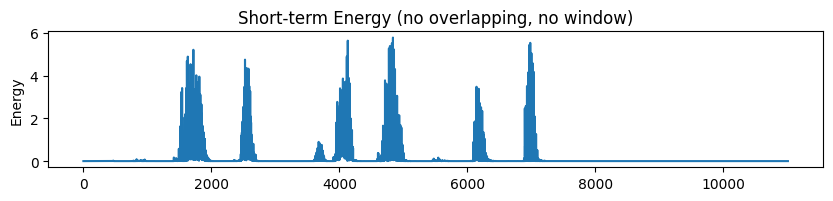

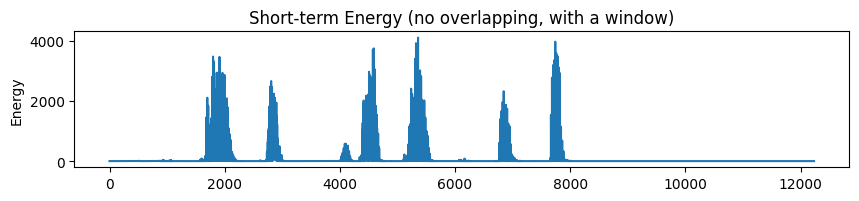

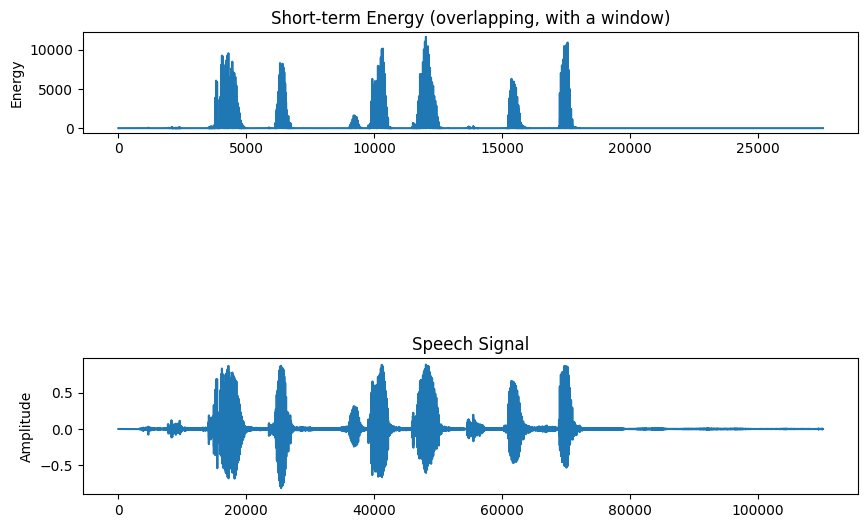

In [ ]:

plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(energ_1)
plt.ylabel('Energy')
plt.title('Short-term Energy (no overlapping, no window)')

plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 2)
plt.plot(energ)
plt.ylabel('Energy')
plt.title('Short-term Energy (no overlapping, with a window)')

plt.figure(figsize=(10, 6))
plt.subplot(4, 1, 1)
plt.plot(energ_0)
plt.ylabel('Energy')
plt.title('Short-term Energy (overlapping, with a window)')

plt.subplot(3, 1, 3)
plt.plot(audio_exp)
plt.ylabel('Amplitude')
plt.title('Speech Signal')

Далее работа ведется с no overlapping yes window STE (short time energy).

The filter coefficient α determines the degree of smoothing applied to the energy values, with smaller values resulting in more smoothing.

In [ ]:
from logging import raiseExceptions

def low_pass_filter(energy, coef):
  smoothed_energ = []
  if 0 > coef or 1 < coef:
    raise ValueError('Коэффициент coef должен быть в диапазоне от 0 до 1')
  for n in range(len(energy)):
    if n == 0: y = coef*energy[n]
    else: y = coef*energy[n]+(1-coef)*energy[n-1]
    smoothed_energ.append(y)
  return smoothed_energ

In [ ]:
smoothed_ste = low_pass_filter(energy=energ, coef=0.8)

Text(0.5, 1.0, 'initial STE')

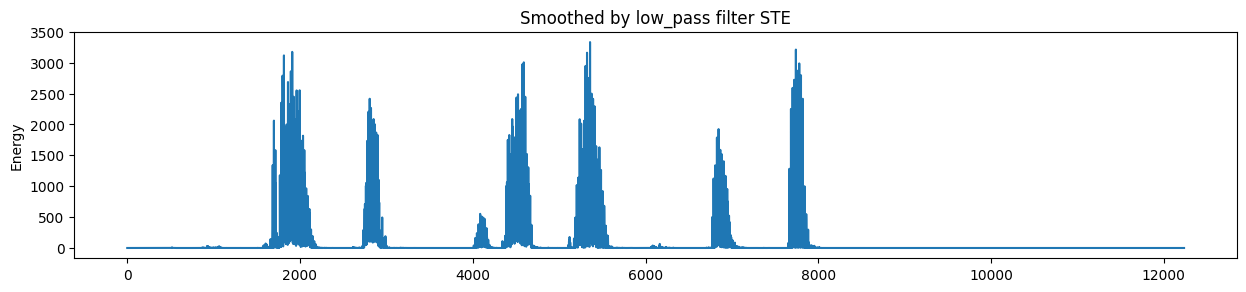

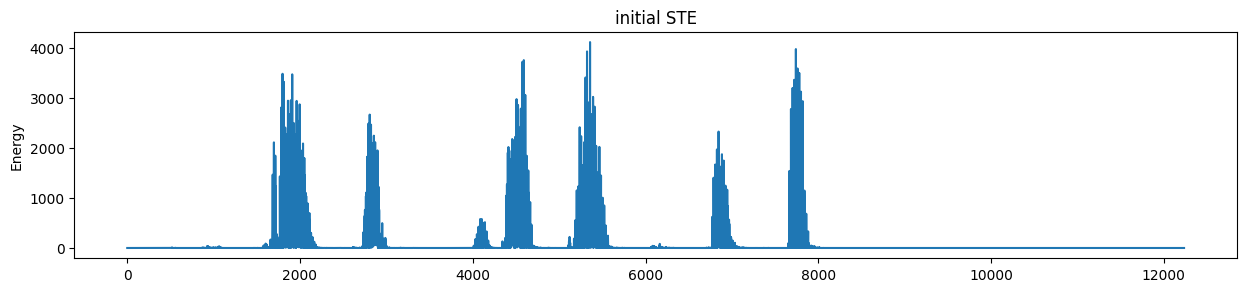

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 2)
plt.plot(smoothed_ste)
plt.ylabel('Energy')
plt.title('Smoothed by low_pass filter STE')

plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 2)
plt.plot(energ)
plt.ylabel('Energy')
plt.title('initial STE')

https://pytorch.org/docs/stable/generated/torch.nn.Threshold.html

При использовании no overlapping no window порог threshold=0.08.

В случае no overlapping yes window порог threshold=&& 1200 пока.

In [ ]:
def threshold_applied(smoothed_energy, threshold):
   smoothed_energy = torch.tensor(smoothed_energy)
   thresholded_ste = torch.threshold(input=smoothed_energy, threshold=threshold, value=0)
   return thresholded_ste

In [ ]:
threshold_ste = threshold_applied(smoothed_energy=smoothed_ste, threshold=1200)

Text(0.5, 1.0, 'Smoothed by low_pass filter STE')

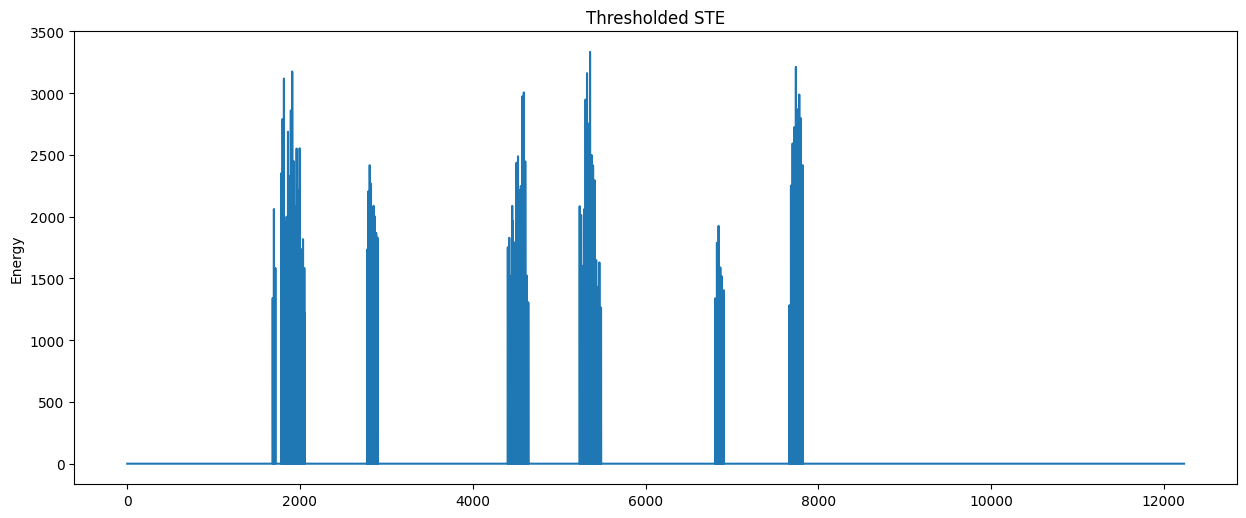

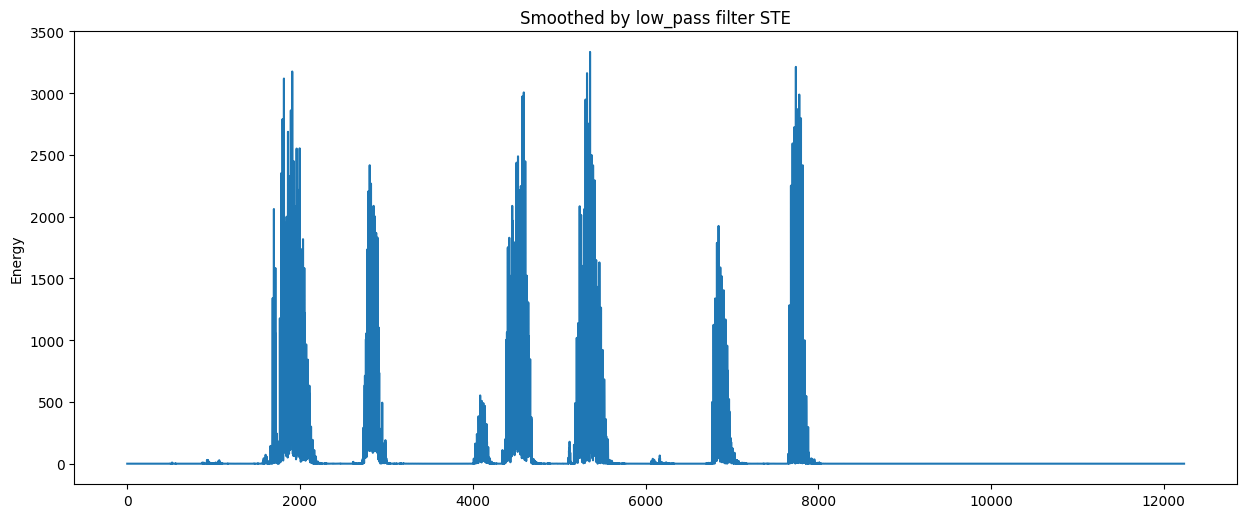

In [ ]:
plt.figure(figsize=(15, 20))
plt.subplot(3, 1, 2)
plt.plot(threshold_ste)
plt.ylabel('Energy')
plt.title('Thresholded STE')

plt.figure(figsize=(15, 20))
plt.subplot(3, 1, 2)
plt.plot(smoothed_ste)
plt.ylabel('Energy')
plt.title('Smoothed by low_pass filter STE')

Преобразование из STE назад в аудио wave.

In [ ]:
def none_windowed_ste_to_signal(signal, cleaned_ste): #без overlapping, но с окном
  frame_length = 9
  framed_signal = librosa.util.frame(x=signal, frame_length=frame_length, axis=0, hop_length=frame_length)
  framed_signal = np.array(framed_signal)
  count_deleted = 0
  for enum, x in enumerate(cleaned_ste):
      if x == 0.0:
        framed_signal = np.delete(framed_signal, enum-count_deleted)
        count_deleted+=1
  new_signal = np.ndarray.flatten(framed_signal)
  return new_signal

Text(0.5, 1.0, 'Old signal')

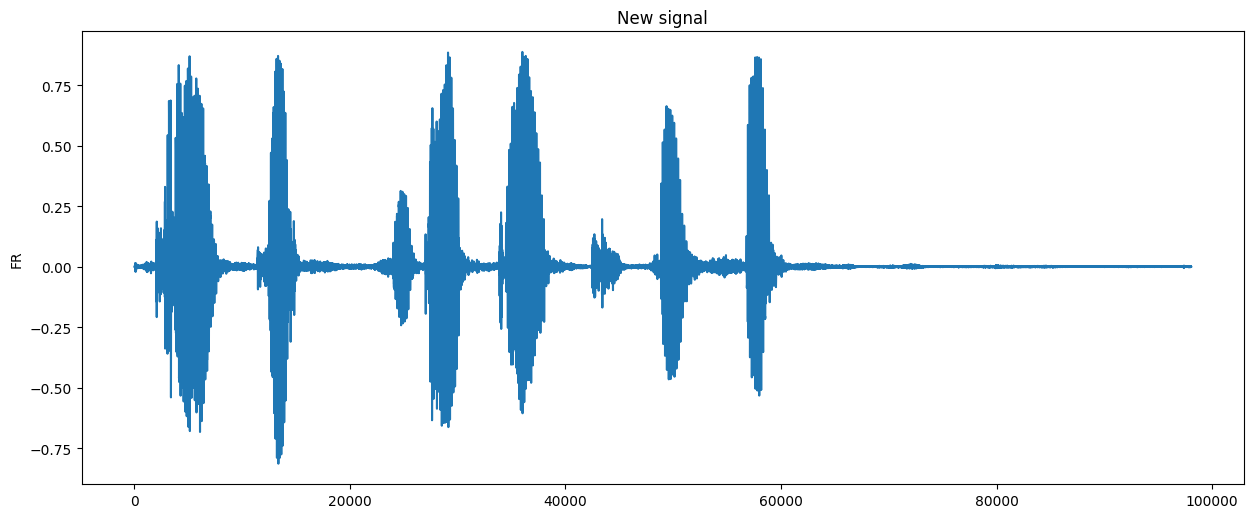

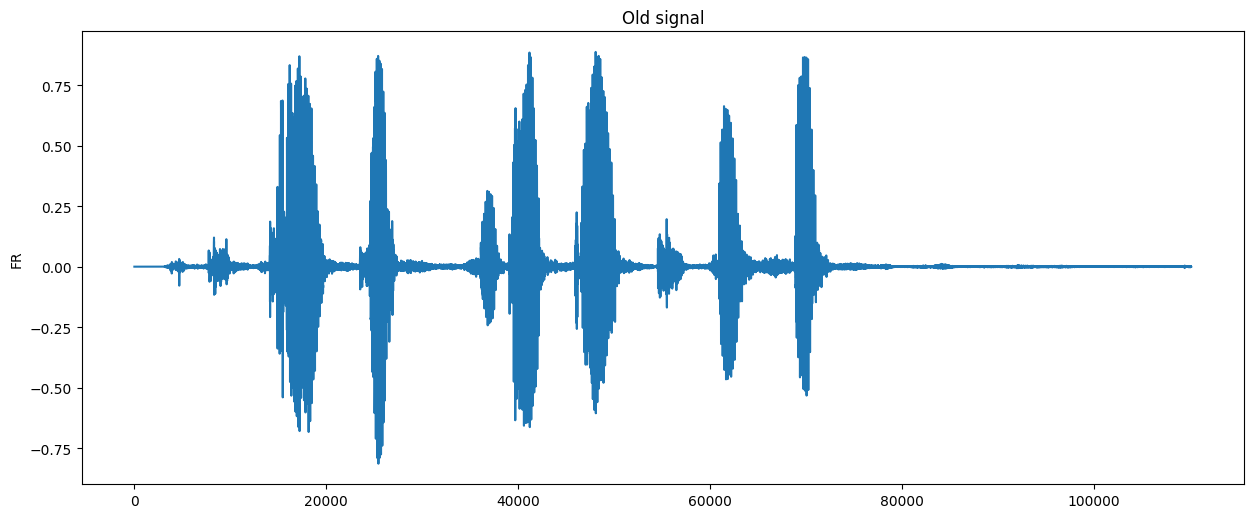

In [ ]:
new_signal = none_windowed_ste_to_signal(audio_exp, threshold_ste)

plt.figure(figsize=(15, 20))
plt.subplot(3, 1, 2)
plt.plot(new_signal)
plt.ylabel('FR')
plt.title('New signal')

plt.figure(figsize=(15, 20))
plt.subplot(3, 1, 2)
plt.plot(audio_exp)
plt.ylabel('FR')
plt.title('Old signal')

Очищенное от шума аудио

In [ ]:
ipd.Audio(data=new_signal, rate=sample_rate)

In [ ]:
ipd.Audio(data=audio_exp, rate=sample_rate)

## Основная загрузка и предобработка

Загрузка аудио.

После приобретения работающей готовой модели ей на вход будет подаваться очищенное предобработанное аудио.
Здесь

*filtered_energy = threshold_applied(low_pass_filter(energy=short_time_energy(sampl), coef=0.5), 5)*

*new_signal = none_windowed_ste_to_signal(sampl, filtered_energy)*

*X.append(torch.Tensor(new_signal))*

представлен пример, что пойдет на вход и в какой очередности преобразовывается.


В настоящий момент эти строки исключены из-за нетребующейся долгой и, возможно, неуместной из-за дальнейшего наложения шума к аудио для обучения текущей модели.

In [ ]:
file = pd.read_excel('/content/Speeches.xlsx')
y = [sentence for sentence in file['Русская речь']]

dir_name = "/content/Disorder Voices/Disorder Voices/"
files_in_dir = os.listdir(dir_name)

X = []
i = 1
sample_rate=22050

for e in range(1, 2001):
    file_name = f'{e}.wav'
    sampl = normalize(librosa.load(dir_name + file_name, sr=sample_rate)[0])
    # filtered_energy = threshold_applied(low_pass_filter(energy=short_time_energy(sampl), coef=0.5), threshold=5)
    # new_signal = none_windowed_ste_to_signal(sampl, filtered_energy)
    # X.append(torch.Tensor(new_signal))
    # sampl = sampl[np.newaxis, :]
    X.append(torch.Tensor(sampl))
    if i % 100 == 0:
        print(i)
    i += 1

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


## Удаление повторов слов

In [ ]:
pip install pydub # библиотека для извлечения слов из аудиосигнала

  Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)


In [ ]:
# Получение оригинального аудиосигнала
test_signal = normalize(librosa.load("/content/Disorder Voices/Disorder Voices/1591.wav")[0])
ipd.Audio(data=test_signal, rate=22050)

In [ ]:
# Получение нормализованного и преобразованного аудиосигнала (сильно обрезается в начале)
filtered_energy_test = threshold_applied(low_pass_filter(energy=short_time_energy(test_signal), coef=0.5), threshold = 1200)
test_signal = none_windowed_ste_to_signal(test_signal, filtered_energy_test)
ipd.Audio(data=test_signal, rate=sample_rate)

In [ ]:
import pydub
from pydub import AudioSegment
from pydub.silence import split_on_silence

In [ ]:
# Нормализация ndarray
test_signal = (test_signal * 32768).astype(np.int16)

# Конвертация ndarray в массив байт
audio_as_bytes = test_signal.tobytes()

# Создание аудиосигнала для последующего его разбиения на слова
audio_segment = pydub.AudioSegment(audio_as_bytes, frame_rate=22059, sample_width=2, channels=1)

In [ ]:
# Загрузка аудиосигнала
# sound_file = AudioSegment.from_wav("/content/Disorder Voices/Disorder Voices/1901.wav")
sound_file = audio_segment

# Разбиение аудисоигнала на части
audio_chunks = split_on_silence(sound_file, min_silence_len=500, silence_thresh=-22)

# Получаем список слов
words_arr = []
for i, chunk in enumerate(audio_chunks):
    out_file = f"chunk{i}.wav"
    chunk.export(out_file, format="wav")
    words_arr.append(out_file)

In [ ]:
for word in words_arr:
  ipd.display(ipd.Audio(word))

In [ ]:
# преобразование аудиосигналов обратно в тип ndarray
words_ndarrays = []
for word in words_arr:
  words_ndarrays.append(librosa.load(word)[0])
print(words_ndarrays)

[array([ 3.94940036e-09, -1.22536585e-08,  4.20571400e-09, ...,
        1.50697604e-02,  1.60394963e-02,  7.89483823e-03], dtype=float32), array([ 0.00268647,  0.00321744,  0.00336225, ..., -0.00855972,
       -0.00606905,  0.        ], dtype=float32), array([3.42466694e-04, 4.64179146e-04, 7.92327264e-05, ...,
       1.15329036e-04, 6.50959410e-05, 0.00000000e+00], dtype=float32), array([-0.00490963, -0.00458759, -0.00439342, ..., -0.02490618,
       -0.0276005 , -0.01958794], dtype=float32)]


Выделение MFCC и LPC признаков (на примере 1 аудиосигнала)

In [ ]:
mfcc_arr = []
for word in words_ndarrays:
  mfcc_arr.append(librosa.feature.mfcc(y=word, sr=22050))
# print(mfcc_arr) # len(mfcc_arr) = 3, len(el) = 20
print(len(mfcc_arr))
print(len(mfcc_arr[2]))
print(len(mfcc_arr[2][19]))
# Для одного слова формируется массив из 20 признаков, в котором еще 30-40 элементов

4
20
42


In [ ]:
lpc_arr = []
for word in words_ndarrays:
  signal = np.float32(word)
  lpc_arr.append(librosa.lpc(signal, order=len(mfcc_arr[0])-1))
# print(lpc_arr) # len(lpc_arr) = 3, len(el) = 17
print(len(lpc_arr[0]))

20


Нахождение корреляции между MFCC и LPC признаками

In [ ]:
mfcc_arr_flattened = [] # сплющили список mfcc-признаков. Теперь для каждого слова у нас от 660 до 800 признаков
for word in mfcc_arr:
  mfcc_arr_flattened.append(word.flatten())
print(len(mfcc_arr_flattened[2]))

840


In [ ]:
from scipy.spatial.distance import cosine

corr_threshold = 0.92
words_to_remove = set()

#Нахождение коэффицентов корреляции:
for i in range(len(mfcc_arr_flattened) - 1):
    for j in range(i+1, len(mfcc_arr_flattened)):
        # Дополнение нулями для векторов разной длины
        len_i = len(mfcc_arr_flattened[i])
        len_j = len(mfcc_arr_flattened[j])
        if len_i < len_j:
            mfcc_arr_flattened[i] = np.pad(mfcc_arr_flattened[i], (0, len_j-len_i), 'constant')
        else:
            mfcc_arr_flattened[j] = np.pad(mfcc_arr_flattened[j], (0, len_i-len_j), 'constant')
        corr_coef = 1 - cosine(mfcc_arr_flattened[i], mfcc_arr_flattened[j])
        if corr_coef >= corr_threshold:
          words_to_remove.add(words_arr[i])
        print(f'Коэффициент корреляции между словом {i+1} и словом {j+1}: {corr_coef}')

Коэффициент корреляции между словом 1 и словом 2: 0.09904010593891144
Коэффициент корреляции между словом 1 и словом 3: 0.164234921336174
Коэффициент корреляции между словом 1 и словом 4: 0.06274725496768951
Коэффициент корреляции между словом 2 и словом 3: 0.19546206295490265
Коэффициент корреляции между словом 2 и словом 4: 0.04538382589817047
Коэффициент корреляции между словом 3 и словом 4: 0.4730587303638458


Удаление повторяющихся слов

In [ ]:
words_arr = [word for word in words_arr if word not in words_to_remove]

Восстановление фразы из слов

In [ ]:
result_file = AudioSegment.empty()

for word in words_arr:
    sound = AudioSegment.from_wav(word)
    result_file += sound

display(result_file)

## Удаление растяжений (в процессе)

1. находится коррелляция фреймов
2. если высокая корреляция - +1 к повторению, низкая - в нуль повторения
3. если повторений больше N, то замечено растяжение. Досчитать повторения до прерывания на точке M и обрезать с N до M.
Исключения мб - паузы

In [ ]:
# from IPython.core.debugger import set_trace

def corr_filter(corr, reps, reps_limit, framed_signal, count_deleted, x):
    if corr[0,1] > 0.2:
      reps+=1
    else: reps=0
    if reps > reps_limit:
      framed_signal = np.delete(framed_signal, x-count_deleted)
      count_deleted+=1
    return framed_signal, reps, count_deleted

def prolongation_reduction(signal, frame_length=20):
  sample_rate = 22050
  framed_signal = librosa.util.frame(x=signal, frame_length=frame_length, axis=0, hop_length=frame_length) #20 фреймов = около 50мс длительностью каждый кадр
  reps = 0
  count_deleted = 0
  reps_limit = 4 #лимит на количество подряд идущих сходных фонем
  for x in range(len(np.array(framed_signal))-1):
    # set_trace()
    # if np.array(framed_signal[x]).shape == ():
    #   break
    current_frame_lpc_feature = librosa.lpc(np.array(framed_signal[x]), order=16)
    next_frame_lpc_feature = librosa.lpc(np.array(framed_signal[x+1]), order=16)
    r1 = np.corrcoef(current_frame_lpc_feature, next_frame_lpc_feature)
    # framed_signal, reps, count_deleted = corr_filter(r1, reps, reps_limit, framed_signal, count_deleted, x)
    if r1[0,1] > 0.1:
      reps+=1
    else: reps=0
    if reps > reps_limit:
      framed_signal = np.delete(framed_signal, x-count_deleted)
      count_deleted+=1

  # for x in range(len(framed_signal)-1):
  #   print(np.array(framed_signal).shape)
  #   if np.array(framed_signal[x]).shape == ():
  #     break
  #   current_frame_mfcc_feature = librosa.feature.mfcc(y=np.array(framed_signal[x]), sr=sample_rate)
  #   next_frame_mfcc_feature = librosa.feature.mfcc(y=np.array(framed_signal[x+1]), sr=sample_rate)
  #   r2 = np.corrcoef(current_frame_mfcc_feature, next_frame_mfcc_feature)
  #   # framed_signal, reps, count_deleted = corr_filter(r2, reps, reps_limit, framed_signal, count_deleted, x)
  #   if r2[0,1] > 0.2:
  #     reps+=1
  #   else: reps=0
  #   if reps > reps_limit:
  #     framed_signal = np.delete(framed_signal, x-count_deleted)
  #     count_deleted+=1

  new_signal = np.ndarray.flatten(framed_signal)
  return new_signal


Не все прогоняются кадры, встречаются пустышки

In [ ]:
import numpy as np

exmp = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1 ,1 ,1]
reps = 0
count_deleted = 0
for x, num in enumerate(exmp):
  if num < 1:
    reps+=1
  else: reps = 0
  if reps >= 1:
    exmp = np.delete(exmp, x-count_deleted)
    count_deleted+=1

print(exmp)

[1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
from google.colab import files

file = files.upload()
audio_exp_prolongation = librosa.load("/content/audio.wav")[0]
# new_audio = prolongation_reduction(audio_exp_prolongation)

Saving audio.wav to audio.wav


пустышки отсутствуют

In [ ]:
framed_signal = librosa.util.frame(x=audio_exp_prolongation[:20000], frame_length=10, axis=0, hop_length=10)
reps = 0
count_deleted = 0
reps_limit = 5 #лимит на количество подряд идущих сходных фонем
new_signal = framed_signal
threshold = 0.08
for x in range(len(np.array(framed_signal))-1):
  current_frame_lpc_feature = librosa.lpc(np.array(framed_signal[x]), order=10)
  next_frame_lpc_feature = librosa.lpc(np.array(framed_signal[x+1]), order=10)
  r1 = np.corrcoef(current_frame_lpc_feature, next_frame_lpc_feature)
  if r1[0,1] > threshold:
    reps+=1
  if reps > reps_limit:
    new_signal = np.delete(new_signal, x-count_deleted, axis=0)
    count_deleted+=1
  if r1[0,1] < threshold: reps=0

framed_signal = new_signal
new_signal = framed_signal
reps = 0
count_deleted = 0

for x in range(len(np.array(framed_signal))-1):
  current_frame_mfcc_feature = librosa.feature.mfcc(y=np.array(framed_signal[x]), sr=22050)
  next_frame_mfcc_feature = librosa.feature.mfcc(y=np.array(framed_signal[x+1]), sr=22050)
  r1 = np.corrcoef(current_frame_mfcc_feature, next_frame_mfcc_feature)
  if r1[0,1] > threshold:
    reps+=1
  if reps > reps_limit:
    new_signal = np.delete(new_signal, x-count_deleted, axis=0)
    count_deleted+=1
  if r1[0,1] < threshold: reps=0

new_aud = np.ndarray.flatten(new_signal)

In [ ]:
ipd.Audio(data=new_aud, rate=22050)

In [ ]:
ipd.Audio(data=audio_exp_prolongation[:20000], rate=22050)

In [ ]:
filtered_energy = threshold_applied(low_pass_filter(energy=short_time_energy(new_aud), coef=0.5), 5)

new_aud = none_windowed_ste_to_signal(new_aud, filtered_energy)

In [ ]:
ipd.Audio(data=new_aud, rate=22050)

# Здесь проходит предобработка фраз

In [ ]:
char_map = {"а": 0, "б": 1, "в": 2, "г": 3, "д": 4, "е": 5, "ё": 6, "ж": 7, "з": 8, "и": 9, "й": 10,
            "к": 11, "л": 12, "м": 13, "н": 14, "о": 15, "п": 16, "р": 17, "с": 18, "т": 19, "у": 20,
            "ф": 21, "ч": 22, "ц": 23, "ш": 24, "щ": 25, "ъ": 26, "ы": 27, "ь": 28, "э": 29, "ю": 30,
            "я": 31, "х": 32, " ": 33}

def remove_characters(sentence):
    sentence = sentence.lower()
    sentence = ''.join(filter(lambda x: x in char_map, sentence))
    return sentence

y = list(map(remove_characters, y))

In [ ]:
len(y)

2000

In [ ]:
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, utterance) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        elif data_type == 'valid':
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            raise Exception('data_type should be train or valid')
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance))
        labels.append(label)
        input_lengths.append(spec.shape[0]//4)
        label_lengths.append(len(label))

    spectrograms1 = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)

    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms1, labels, input_lengths, label_lengths

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


#WER, CER, leventain distance + кодирование и декодирование

In [ ]:
def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)


def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein disctance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in word-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Levenshtein distance and word number of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in char-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Levenshtein distance and length of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text in word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words subsituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    We can use levenshtein distance to calculate WER. Please draw an attention
    that empty items will be removed when splitting sentences by delimiter.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Word error rate.
    :rtype: float
    :raises ValueError: If word number of reference is zero.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). CER compares reference text and
    hypothesis text in char-level. CER is defined as:
    .. math::
        CER = (Sc + Dc + Ic) / Nc
    where
    .. code-block:: text
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    We can use levenshtein distance to calculate CER. Chinese input should be
    encoded to unicode. Please draw an attention that the leading and tailing
    space characters will be truncated and multiple consecutive space
    characters in a sentence will be replaced by one space character.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Character error rate.
    :rtype: float
    :raises ValueError: If the reference length is zero.
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        self.char_map = {"а": 0, "б": 1, "в": 2, "г": 3, "д": 4, "е": 5, "ё": 6, "ж": 7, "з": 8, "и": 9, "й": 10,
                  "к": 11, "л": 12, "м": 13, "н": 14, "о": 15, "п": 16, "р": 17, "с": 18, "т": 19, "у": 20,
                  "ф": 21, "ч": 22, "ц": 23, "ш": 24, "щ": 25, "ъ": 26, "ы": 27, "ь": 28, "э": 29, "ю": 30,
                  "я": 31, "х": 32, " ": 33}

        self.index_map = {}
        for key, value in self.char_map.items():
            self.index_map[value] = key

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c != '':
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string)

text_transform = TextTransform()

def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets